## Import library

In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
import albumentations as A
import torch.nn as nn
import cv2
import time
import torch.nn.functional as F
from torchvision import transforms as T
import copy
from tqdm.notebook import tqdm
import timm
from torchsummary import summary
import sys
import math

## Connect to Cuda

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# seed
torch.manual_seed(4)

## Initialize data directory

In [4]:
DATA_DIR = "D:\\Documents\\FYP-technical\\Processed4"

## Load data and split
Make Chunk 10 and Chunk 4 as validation data.

In [5]:
vid_list = os.listdir(DATA_DIR)
len(vid_list)

1139

In [6]:
train_data_list = []
val_data_list = []
for vid in vid_list:
        
    vid_data_list = os.listdir(DATA_DIR + "\\" + vid)
    
    if vid.startswith('Chunk10') or vid.startswith('Chunk4'):
        val_data_list += [vid + "\\" + x[:4] for x in vid_data_list if x.endswith('_data.csv')]
    else:
        train_data_list += [vid + "\\" + x[:4] for x in vid_data_list if x.endswith('_data.csv')]
    

print("Number of training data: " + str(len(train_data_list)))
print("Number of validation data: " + str(len(val_data_list)))
print("Total data: " + str(len(train_data_list) + len(val_data_list)))

Number of training data: 24938
Number of validation data: 11526
Total data: 36464


## Initialize model

In [8]:
model = timm.create_model('efficientnet_lite0', pretrained=True)

In [9]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=512),
    nn.Linear(in_features=512, out_features=300),
    nn.Unflatten(1, (100, 3))
)

In [10]:
summary(model, (3, 320,416), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 208]             864
       BatchNorm2d-2         [-1, 32, 160, 208]              64
             ReLU6-3         [-1, 32, 160, 208]               0
            Conv2d-4         [-1, 32, 160, 208]             288
       BatchNorm2d-5         [-1, 32, 160, 208]              64
             ReLU6-6         [-1, 32, 160, 208]               0
          Identity-7         [-1, 32, 160, 208]               0
            Conv2d-8         [-1, 16, 160, 208]             512
       BatchNorm2d-9         [-1, 16, 160, 208]              32
         Identity-10         [-1, 16, 160, 208]               0
DepthwiseSeparableConv-11         [-1, 16, 160, 208]               0
           Conv2d-12         [-1, 96, 160, 208]           1,536
      BatchNorm2d-13         [-1, 96, 160, 208]             192
            ReLU6-14         [-1, 

In [11]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU6(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU6(inplace=True)
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_

## Dataset class

In [12]:
class RoadPathDataset(Dataset):
    
    def __init__(self, data_path, data_list, img_preprocess, data_preprocess, transform=None):
        self.data_path = data_path
        self.data_list = data_list
        self.transform = transform
        self.img_preprocess = img_preprocess
        self.data_preprocess = data_preprocess
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.data_path + "\\" + self.data_list[idx] + "_img.jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        path = np.genfromtxt(self.data_path + "\\" + self.data_list[idx] + "_data.csv",delimiter=',')
        
        if self.transform:
            aug = self.transform(image=img)
            img = Image.fromarray(aug['image'])
        
        if self.img_preprocess:
            img = self.img_preprocess(img)
        
        if self.data_preprocess:
            path = self.data_preprocess(path)
            path = torch.squeeze(path, 0)
            
        return img, path

In [13]:
## transform
train_transform = A.Compose([
                A.augmentations.transforms.GaussNoise(p=0.2),
                A.OneOf(
                    [A.CLAHE(p=1.0),
                    A.RandomGamma(p=1.0),
                    ],p=0.5),
                A.OneOf(
                    [A.augmentations.transforms.Sharpen(p=1.0),
                    A.Blur(blur_limit=3, p=1.0),
                    A.MotionBlur(blur_limit=3, p=1.0),
                    ],p=0.5),
                A.OneOf(
                    [A.HueSaturationValue(p=1.0),
                     A.RGBShift(1.0)
                    ],p=0.5),
                A.Resize(height=320, width=416, p=1.0), ## need to be multiple of 32
            ], p=1.0)

val_transform = A.Compose([
            A.Resize(height=320, width=416, p=1.0),
        ], p=1.0)

## image preprocess 
img_preprocess = T.Compose([
    T.ToTensor(), 
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ## mean and standard deviation
])

## target preprocess 
data_preprocess = T.Compose([
    T.ToTensor()
])

In [14]:
train_data = RoadPathDataset(
                data_path = DATA_DIR, 
                data_list = train_data_list,
                img_preprocess = img_preprocess,
                data_preprocess = data_preprocess,
                transform = train_transform
                )

val_data = RoadPathDataset(
                data_path = DATA_DIR, 
                data_list = val_data_list,
                img_preprocess = img_preprocess,
                data_preprocess = data_preprocess,
                transform = val_transform
                )

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=True)

In [14]:
def get_target_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for _, target in tqdm(dataloader, leave=True):
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(torch.mean(target, 1), 0)
        channels_squared_sum += torch.mean(torch.mean(target**2, 1), 0)
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [88]:
# get_target_mean_and_std(train_loader)

(tensor([35.4279,  0.7769, -1.7467], dtype=torch.float64),
 tensor([22.9786,  1.4706,  1.3428], dtype=torch.float64))

In [15]:
class TargetNormalize(object):
    def __call__(self, x):
        mean = torch.tensor([35.4279,  0.7769, -1.7467])
        std = torch.tensor([22.9786,  1.4706,  1.3428])
        x_normed = (x - mean) / std
        return x_normed

In [16]:
## target preprocess 
data_preprocess = T.Compose([
    T.ToTensor(),
    TargetNormalize()
])

In [17]:
train_data = RoadPathDataset(
                data_path = DATA_DIR, 
                data_list = train_data_list,
                img_preprocess = img_preprocess,
                data_preprocess = data_preprocess,
                transform = train_transform
                )

val_data = RoadPathDataset(
                data_path = DATA_DIR, 
                data_list = val_data_list,
                img_preprocess = img_preprocess,
                data_preprocess = data_preprocess,
                transform = val_transform
                )

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=True)

## Loss function, optimizer, lr scheduler, metrics

In [18]:
max_lr = 1e-3
epoch = 10
weight_decay = 1e-4

criterion = nn.L1Loss()
criterion.__name__ = "mean_absolute_loss"
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

In [19]:
from utils.metrics import MeanIoU
metrics = [MeanIoU()]

In [20]:
from utils.train import TrainEpoch, ValidEpoch

In [21]:
def train(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler, metrics, device):
    
    fit_time = time.time()
    min_loss = np.inf
    train_loss = []; val_loss = []
    train_iou = []; val_iou = []
    
    
    ## create epoch runners
    train_epoch = TrainEpoch(
        model, 
        loss=criterion, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=True,
    )
    
    val_epoch = ValidEpoch(
        model, 
        loss=criterion, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )

    for e in range(epoch):
        print('Epoch {}/{}'.format(e+1, epoch))
        print('-' * 10)
        since = time.time()
        
        train_logs = train_epoch.run(train_loader)
        val_logs = val_epoch.run(val_loader)
        
        ## step lr
        scheduler.step() 
        
        ## store metrics 
        train_loss.append(train_logs['mean_absolute_loss'])
        train_iou.append(train_logs['mean_iou'])
        
        val_loss.append(val_logs['mean_absolute_loss'])
        val_iou.append(val_logs['mean_iou'])
            

        torch.save(model.state_dict(), './eff_model-lite-epoch-'+ str(e) +'.pth')

        print("Time: {:.2f}m".format((time.time()-since)/60))
        print()
                      
    print('Least Val Loss: {:4f}'.format(min_loss))
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
        
    history = {'train_loss' : train_loss, 'val_loss': val_loss,
               'train_iou' :train_iou, 'val_iou':val_iou,
              }
    return history

In [22]:
train_history = train(epoch, model, 
                     train_loader, val_loader, 
                     criterion, optimizer, sched, 
                     metrics, device)

Epoch 1/10
----------
valid: 100%|████████████████████████| 2882/2882 [28:56<00:00,  1.66it/s, mean_absolute_loss - 0.2736, mean_iou - 0.868]
Time: 147.06m

Epoch 2/10
----------
valid: 100%|███████████████████████| 2882/2882 [27:05<00:00,  1.77it/s, mean_absolute_loss - 0.2385, mean_iou - 0.8309]
Time: 137.57m

Epoch 3/10
----------
valid: 100%|███████████████████████| 2882/2882 [27:45<00:00,  1.73it/s, mean_absolute_loss - 0.2311, mean_iou - 0.8347]
Time: 138.48m

Epoch 4/10
----------
valid: 100%|█████████████████████████| 2882/2882 [27:19<00:00,  1.76it/s, mean_absolute_loss - 0.21, mean_iou - 0.7518]
Time: 137.00m

Epoch 5/10
----------
valid: 100%|███████████████████████| 2882/2882 [26:34<00:00,  1.81it/s, mean_absolute_loss - 0.2048, mean_iou - 0.8371]
Time: 135.55m

Epoch 6/10
----------
valid: 100%|████████████████████████| 2882/2882 [27:08<00:00,  1.77it/s, mean_absolute_loss - 0.198, mean_iou - 0.9178]
Time: 138.69m

Epoch 7/10
----------
valid: 100%|███████████████████████|

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [23]:
train_history

{'train_loss': [0.36605452943799377,
  0.23844949735303173,
  0.20472279875132243,
  0.18671753273107233,
  0.17363083035518584,
  0.16439439505278905,
  0.15666411144908382,
  0.14913153674964424,
  0.1432340840034555,
  0.13772125569647983],
 'val_loss': [0.273599623948707,
  0.23854959096906975,
  0.23113348867839856,
  0.20998620956820785,
  0.20480225990234857,
  0.19798440016976718,
  0.19685596169737105,
  0.19355825501792057,
  0.19838621022049158,
  0.1879921004416559],
 'train_iou': [0.7390928014623356,
  0.8331628372359473,
  0.8733502718526688,
  0.8942360411000048,
  0.9100795810998883,
  0.9236148648197038,
  0.9310251938885632,
  0.9364548438390737,
  0.9417101777928684,
  0.946966520948416],
 'val_iou': [0.8679739873827853,
  0.8308704941534165,
  0.8347452201523098,
  0.7517680446775646,
  0.8371213144473441,
  0.9177681823454336,
  0.7889189386661477,
  0.8920008924109165,
  0.8762507142084149,
  0.8949710853516764]}

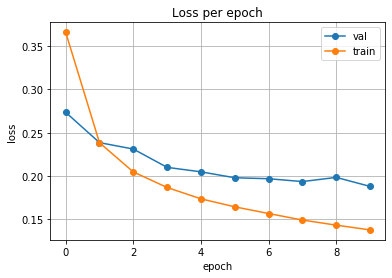

In [24]:
## plot loss by epoch
plt.plot(train_history['val_loss'], label='val', marker='o')
plt.plot( train_history['train_loss'], label='train', marker='o')
plt.title('Loss per epoch'); plt.ylabel('loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

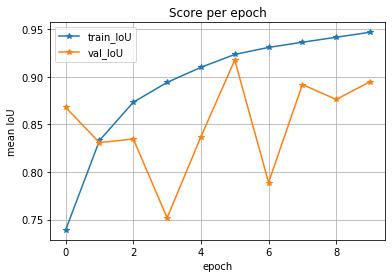

In [25]:
## plot iou score by epoch
plt.plot(train_history['train_iou'], label='train_IoU', marker='*')
plt.plot(train_history['val_iou'], label='val_IoU',  marker='*')
plt.title('Score per epoch'); plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()